In [105]:
# Импорт библиотек
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, precision_score, \
    recall_score, f1_score

In [106]:
# Загрузка датасетов
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
pd.set_option('display.max_columns', None)
print('Размер тренировочной выборки: ', data_train.shape)
display(data_train.head(3))
print('Размер тестовой выборки: ', data_test.shape)
display(data_test.head(3))

Размер тренировочной выборки:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0


Размер тестовой выборки:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y


### Подготовка данных

In [107]:
# маркировка сетов и их дальнейшее объединение для более полного обучения
data_train['Set'] = 0
data_test['Set'] = 1

df = data_train.append(data_test, sort=False).reset_index(drop=True)

In [108]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Set
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,0


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [110]:
df.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Set                     0
dtype: int64

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64


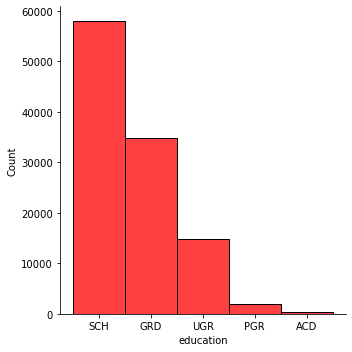

In [111]:
sns.displot(df['education'], bins=5, color='red')
print(df['education'].value_counts())

In [112]:
# заполним пропуски медианным значением UGR
df['education'] = df['education'].fillna('UGR')

In [113]:
# Разделим для удобства все признаки
# временные
date_cols = ['app_date']
# бинарные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные
cat_cols = ['education', 'work_address', 'home_address',
            'sna', 'region_rating', 'first_time']
# числовые
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']

In [114]:
# временной признак преобразуем к формату
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')

In [115]:
# выясняем в каком промежутке дат подавались заявки
start = df.app_date.min()
end = df.app_date.max()
start, end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

<AxesSubplot:xlabel='app_date', ylabel='default'>

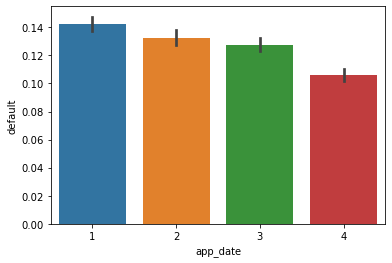

In [116]:
sns.barplot(data=df[df['Set'] == 0], x=df.loc[df['Set']
                                              == 0, 'app_date'].dt.month, y='default')

In [117]:
df['month'] = df.app_date.dt.month

In [118]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Set,month
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,0,2
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,0,3
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,0,2
3,16222,2014-01-23,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,0,1
4,101655,2014-04-18,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,0,4


In [119]:
# добавим новый признак в числовые
num_cols.append('month')

### Преобразование числовых признаков

<Figure size 432x288 with 0 Axes>

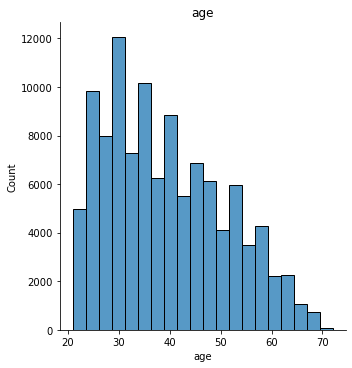

<Figure size 432x288 with 0 Axes>

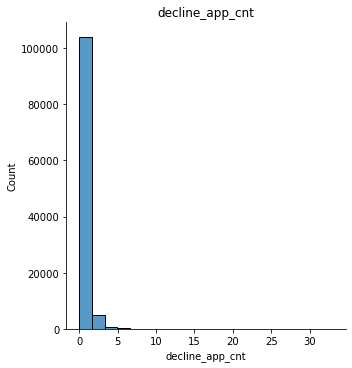

<Figure size 432x288 with 0 Axes>

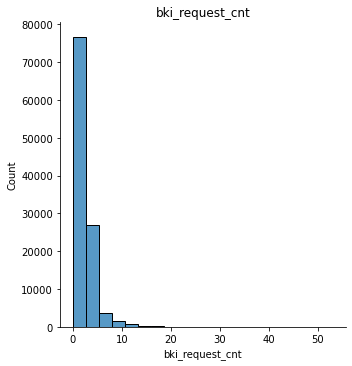

<Figure size 432x288 with 0 Axes>

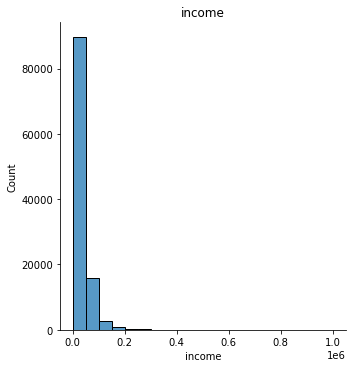

<Figure size 432x288 with 0 Axes>

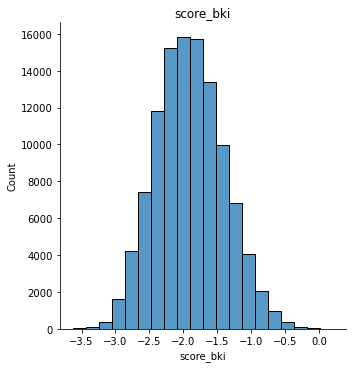

<Figure size 432x288 with 0 Axes>

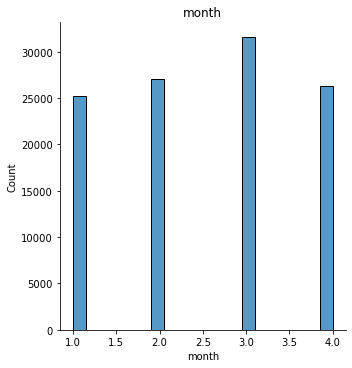

In [120]:
for i in num_cols:
    plt.figure()
    sns.displot(df[i], bins=20, kde=False, rug=False)
    plt.title(i)
    plt.show()

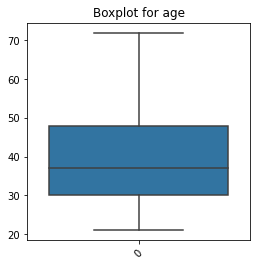

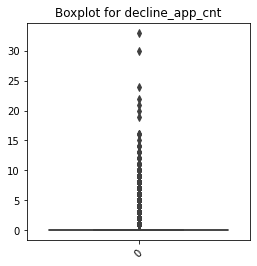

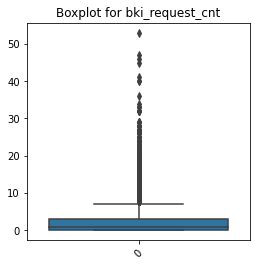

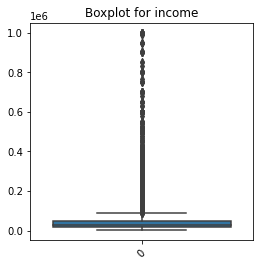

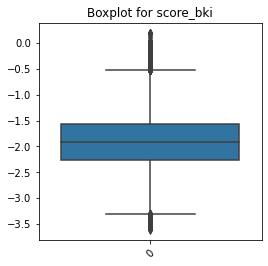

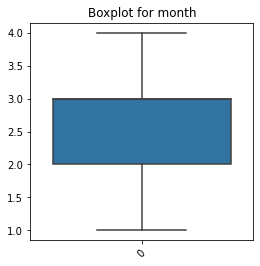

In [121]:
for col in num_cols:
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.boxplot(data=df[col], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + col)
    plt.show()

<Figure size 432x288 with 0 Axes>

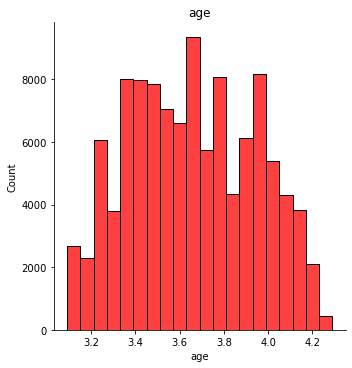

<Figure size 432x288 with 0 Axes>

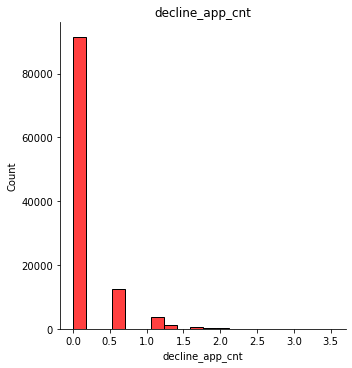

<Figure size 432x288 with 0 Axes>

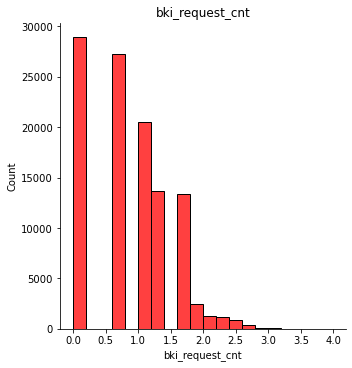

<Figure size 432x288 with 0 Axes>

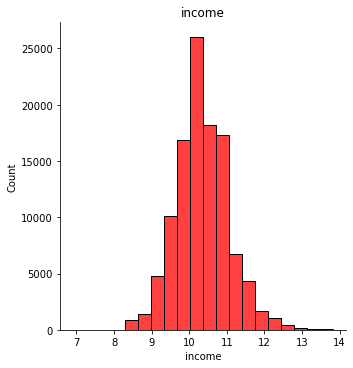

<Figure size 432x288 with 0 Axes>

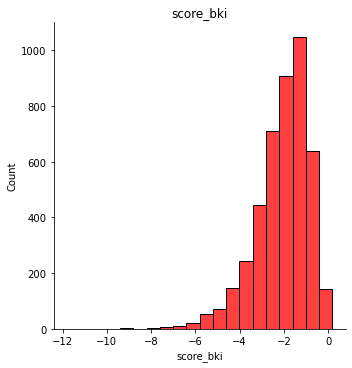

<Figure size 432x288 with 0 Axes>

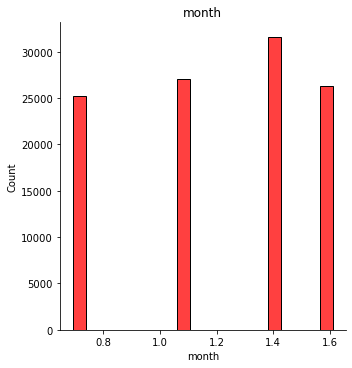

In [122]:
for i in num_cols:
    plt.figure()
    sns.displot(np.log((df[i])+1), color='red', bins=20, kde=False, rug=False)
    plt.title(i)
    plt.show()

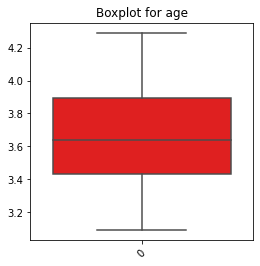

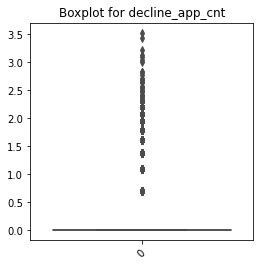

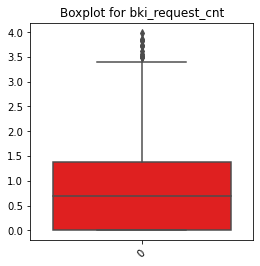

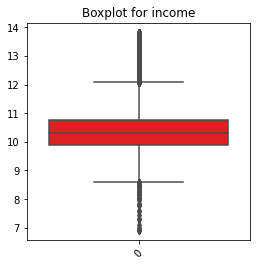

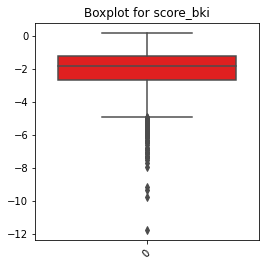

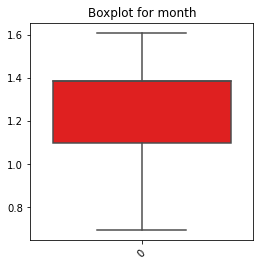

In [123]:
for col in num_cols:
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.boxplot(data=np.log((df[col])+1), color='red', ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + col)
    plt.show()

In [124]:
# логарифмируем необходимые признаки по итогам анализа графиков
df['age'] = np.log(df['age'] + 1)
df['decline_app_cnt'] = np.log(df['decline_app_cnt'] + 1)
df['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)
df['income'] = np.log(df['income'] + 1)
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Set,month
0,25905,2014-02-01,SCH,M,4.143135,Y,Y,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,N,0.0,0,2
1,63161,2014-03-12,SCH,F,4.094345,N,N,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,N,0.0,0,3
2,25887,2014-02-01,SCH,M,3.258097,Y,N,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,Y,0.0,0,2
3,16222,2014-01-23,SCH,F,3.988984,N,N,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,N,0.0,0,1
4,101655,2014-04-18,GRD,M,3.891820,N,N,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,Y,0.0,0,4


### Преобразование категориальных и бинарных признаков

In [125]:
# бинарные признаки с известными ограничениями можем преобразовать с помощью LabelEncoder
label_encoder = LabelEncoder()

for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])

# убедимся в преобразовании
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Set,month
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0.0,0,2
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0.0,0,3
2,25887,2014-02-01,SCH,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0.0,0,2
3,16222,2014-01-23,SCH,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0.0,0,1
4,101655,2014-04-18,GRD,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0.0,0,4


In [126]:
# Из категориальных необходимо преобразовать education
label_encoder = LabelEncoder()
df['education'] = label_encoder.fit_transform(df['education'])

# убедимся в преобразовании
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Set,month
0,25905,2014-02-01,3,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0.0,0,2
1,63161,2014-03-12,3,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0.0,0,3
2,25887,2014-02-01,3,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0.0,0,2
3,16222,2014-01-23,3,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0.0,0,1
4,101655,2014-04-18,1,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0.0,0,4


<Figure size 432x288 with 0 Axes>

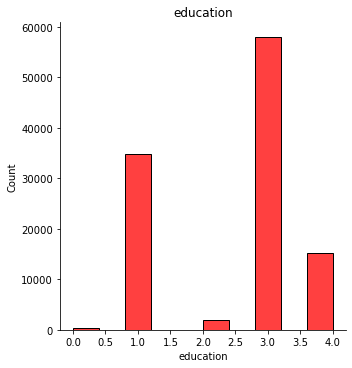

<Figure size 432x288 with 0 Axes>

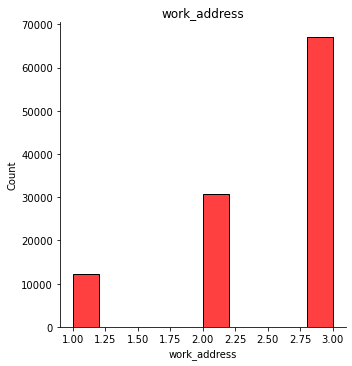

<Figure size 432x288 with 0 Axes>

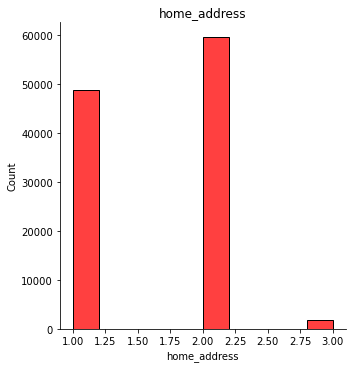

<Figure size 432x288 with 0 Axes>

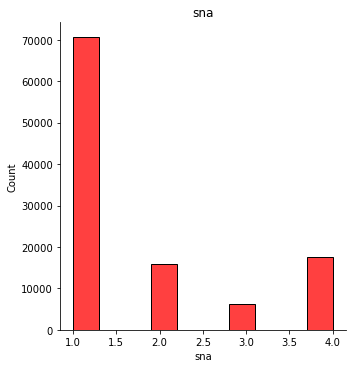

<Figure size 432x288 with 0 Axes>

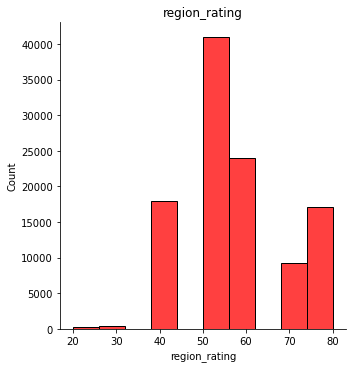

<Figure size 432x288 with 0 Axes>

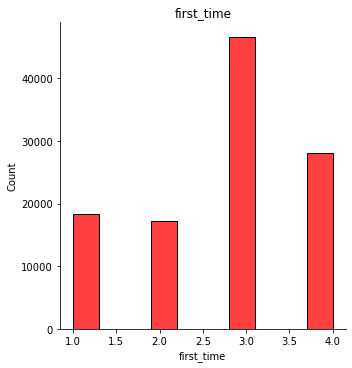

In [127]:
for i in cat_cols:
    plt.figure()
    sns.displot(df[i], color='red', bins=10, kde=False, rug=False)
    plt.title(i)
    plt.show()

<AxesSubplot:>

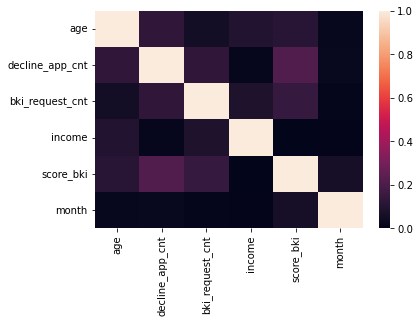

In [128]:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)  # корреляция Пирсона

<AxesSubplot:>

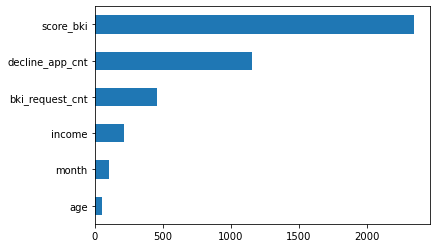

In [129]:
# Оценим на тренировочной выборке важность числовых признаков
train_df = df[df['Set'] == 0]

imp_num = pd.Series(f_classif(train_df[num_cols], train_df['default'])[
                    0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

<AxesSubplot:>

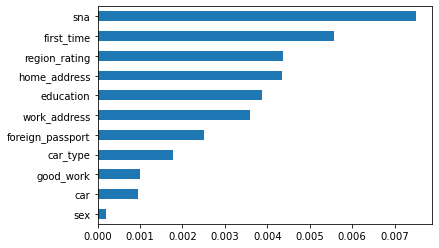

In [130]:
# Оценим на тренировочной выборке важность категорияльных и бинарных признаков
imp_cat = Series(mutual_info_classif(train_df[bin_cols + cat_cols], train_df['default'],
                                     discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

### Подготовка данных к машинному обучению

In [131]:
# удаляем временной признак
df.drop('app_date', axis=1, inplace=True)

In [132]:
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Set,month
0,25905,3,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0.0,0,2
1,63161,3,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0.0,0,3
2,25887,3,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0.0,0,2
3,16222,3,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0.0,0,1
4,101655,1,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0.0,0,4


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  int32  
 2   sex               110148 non-null  int32  
 3   age               110148 non-null  float64
 4   car               110148 non-null  int32  
 5   car_type          110148 non-null  int32  
 6   decline_app_cnt   110148 non-null  float64
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  float64
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  float64
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

In [134]:
# разделяем обратно данные
train = df.query('Set == 0').drop(['Set'], axis=1)
test = df.query('Set == 1').drop(['Set'], axis=1)

In [135]:
X_cat = OneHotEncoder(sparse=False).fit_transform(train[cat_cols].values)

In [136]:
X_num = train[num_cols].values

In [137]:
# Объединяем

X = np.hstack([X_num, train[bin_cols].values, X_cat])
Y = train['default'].values

In [138]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42)

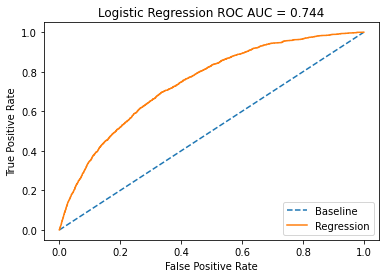

In [139]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
# Рисуем ROC кривую
probs = model.predict_proba(X_test)
probs = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [140]:
confusion_matrix(y_test, y_pred)

array([[12871,    62],
       [ 1787,    40]], dtype=int64)

In [141]:
# Выведем резултат в удобном виде
def matrix(y_true, y_pred, y_pred_prob):
    metrics = {}
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    metrics['True Positive, TP'] = [TP, 'правильно угадали дефолтного']
    metrics['True Negative, TN'] = [TN, 'правильно угадали не дефолтного']
    metrics['False Positive, FP'] = [FP, 'неправильно угадали дефолтного']
    metrics['False Negative, FN'] = [FN, 'неправильно угадали не дефолтного']
    metrics['Recall'] = [recall_score(
        y_true, y_pred), 'полнота позитивных сэмплов']
    metrics['F1-score'] = [f1_score(y_true, y_pred),
                           'соотношение точности и полноты']
    metrics['ROC_AUC'] = [roc_auc_score(y_true, y_pred_prob), 'TPR+FPR']

    data = pd.DataFrame.from_dict(metrics, orient='index', columns=[
                                  'Value', 'Description'])
    display(data)


matrix(y_test, y_pred, y_pred_prob)

,Value,Description
"True Positive, TP",40.000000,правильно угадали дефолтного
"True Negative, TN",12871.000000,правильно угадали не дефолтного
"False Positive, FP",62.000000,неправильно угадали дефолтного
"False Negative, FN",1787.000000,неправильно угадали не дефолтного
Recall,0.021894,полнота позитивных сэмплов
F1-score,0.041472,соотношение точности и полноты
ROC_AUC,0.744126,TPR+FPR


In [142]:
import warnings
warnings.filterwarnings("ignore")

In [143]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

eps = 1e-3
iterat = 100
parameters = [
    {'penalty': ['l1'],
     'solver': ['liblinear', 'lbfgs', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr', 'multinomial'],
     'max_iter':[iterat],
     'tol':[eps]},
    {'penalty': ['l2'],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr', 'multinomial'],
     'max_iter':[iterat],
     'tol':[eps]},
    {'penalty': ['elasticnet'],
     'solver': ['newton-cg', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr', 'multinomial'],
     'max_iter':[iterat],
     'tol':[eps]},
]

clf = GridSearchCV(model, parameters, cv=5, scoring='f1')
clf.fit(X_train, y_train)
model = clf.best_estimator_
best_parameters = model.get_params()
for parameters in sorted(best_parameters.keys()):
    print('\t%s: %r' % (parameters, best_parameters[parameters]))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 100
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'lbfgs'
	tol: 0.001
	verbose: 0
	warm_start: False


In [144]:
# модель на параметрах после оптимизации
model = LogisticRegression(C=1,
                           class_weight='balanced',
                           dual=False,
                           fit_intercept=True,
                           intercept_scaling=1,
                           l1_ratio=None,
                           multi_class='auto',
                           max_iter=100,
                           n_jobs=None,
                           penalty='l2',
                           random_state=42,
                           solver='lbfgs',
                           tol=1e-3,
                           verbose=0,
                           warm_start=False)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

In [145]:
confusion_matrix(y_test, y_pred)

array([[8644, 4289],
       [ 571, 1256]], dtype=int64)

In [146]:
matrix(y_test, y_pred, y_pred_prob)

,Value,Description
"True Positive, TP",1256.000000,правильно угадали дефолтного
"True Negative, TN",8644.000000,правильно угадали не дефолтного
"False Positive, FP",4289.000000,неправильно угадали дефолтного
"False Negative, FN",571.000000,неправильно угадали не дефолтного
Recall,0.687466,полнота позитивных сэмплов
F1-score,0.340749,соотношение точности и полноты
ROC_AUC,0.743691,TPR+FPR


### Submit

In [156]:
X_train = train.drop(['default', 'client_id'], axis=1)
y_train = train.default.values
X_test = test.drop(['default', 'client_id'], axis=1)

In [148]:
test.shape, train.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 19), (73799, 19), (73799, 18), (73799,), (36349, 18))

In [157]:
model = LogisticRegression(C=1,
                           class_weight='balanced',
                           fit_intercept=True,
                           intercept_scaling=1,
                           multi_class='auto',
                           max_iter=1000,
                           penalty='l2',
                           random_state=42,
                           solver='lbfgs',
                           tol=1e-3,
                           verbose=0,
                           warm_start=False)

model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=1000, random_state=42,
                   tol=0.001)

In [158]:
y_pred_prob = model.predict_proba(X_test)[:, 1]

submit = pd.DataFrame(test.client_id)
submit['default'] = y_pred_prob
submit.to_csv('submission.csv', index=False)